### Notebook for the fetal data from Elemtaite 2021 anndata file preparation for RNA velocity analysis
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Creation date:** 30th of May 2024
- **Last modified date:** 24th of June 2024

### Import packages

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci
import anndata as ad
from scipy import io,sparse
import os

### Prepare anndata object

In [2]:
def starsolo_velocity_anndata(input_dir):
    """
    input directory should contain barcodes.tsv, features.tsv with 3 mtx from spliced, ambigious, unspliced
    """
    obs = pd.read_csv(os.path.join(input_dir,'barcodes.tsv'), header = None, index_col = 0)
    # Remove index column name to make it compliant with the anndata format
    obs.index.name = None

    var = pd.read_csv(os.path.join(input_dir,"features.tsv"), sep='\t',names = ('gene_ids', 'feature_types'), index_col = 1)
    var.index.name = None

    spliced=sci.sparse.csr_matrix(sci.io.mmread(os.path.join(input_dir,"spliced.mtx")).T)
    ambiguous=sci.sparse.csr_matrix(sci.io.mmread(os.path.join(input_dir,"ambiguous.mtx")).T)
    unspliced=sci.sparse.csr_matrix(sci.io.mmread(os.path.join(input_dir,"unspliced.mtx")).T)
    adata=ad.AnnData(X=spliced,obs=obs,var=var,layers={'spliced':spliced,"ambiguous":ambiguous,"unspliced":unspliced})
    adata.var_names_make_unique()
    return adata

In [36]:
adata = starsolo_velocity_anndata('/mnt/LaCIE/annaM/gut_project/raw_data/Elmentaite_2021/remapped_fetal_data_E-MTAB-9536_starsolo/FCA_gut8015057/FCA_gut8015057/Velocyto/raw')

In [37]:
adata.obs

""
AAACCTGAGAAACCAT
AAACCTGAGAAACCGC
AAACCTGAGAAACCTA
AAACCTGAGAAACGAG
AAACCTGAGAAACGCC
...
TTTGTCATCTTTACAC
TTTGTCATCTTTACGT
TTTGTCATCTTTAGGG
TTTGTCATCTTTAGTC


+ GTF manipulations

In [17]:
gtf_path = '/mnt/LaCIE/annaM/human_reference_genome/Combined_annotations/expanded_gtf_annotation.gtf'

In [18]:
gtf_df = pd.read_csv(
    gtf_path,
    sep='\t',
    comment='#',
    header=None,
    names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']
)


In [19]:
gtf_df = gtf_df[gtf_df['feature'] != 'exon']

gtf_df = gtf_df.drop(columns=['score', 'strand', 'frame'])

In [20]:
split_columns = gtf_df['attribute'].str.split(';', expand=True)
gtf_df = pd.concat([gtf_df.drop(columns=['attribute']), split_columns], axis=1)

In [21]:
gtf_df.rename(columns={0: 'transcript_id', 1: 'gene_id', 2: 'gene_name', 3: 'ensembl_trancsript_id_old', 4: 'ensembl_trancsript_id_cmp_ref'}, inplace=True)

gtf_df = gtf_df.drop(columns=[5, 6, 7, 8, 9, 10])

In [22]:
gtf_df["transcript_id"] = gtf_df["transcript_id"].str.extract(r'transcript_id "([^"]+)"')
gtf_df["gene_name"] = gtf_df["gene_name"].str.extract(r'gene_name "([^"]+)"')
gtf_df["gene_id"] = gtf_df["gene_id"].str.extract(r'gene_id "([^"]+)"')
gtf_df["ensembl_trancsript_id_old"] = gtf_df["ensembl_trancsript_id_old"].str.extract(r'oId "([^"]+)"')
gtf_df["ensembl_trancsript_id_cmp_ref"] = gtf_df["ensembl_trancsript_id_cmp_ref"].str.extract(r'cmp_ref "([^"]+)"')

+ Calculate transcript length

In [25]:
# Calculate transcript length
gtf_df['transcript_length'] = gtf_df['end'] - gtf_df['start'] + 1


In [39]:
gtf_df.head()

,seqname,source,feature,start,end,transcript_id,gene_name,ensembl_trancsript_id_old,ensembl_trancsript_id_cmp_ref,transcript_length
gene_id,,,,,,,,,,
XLOC_000001,GL000009.2,ENSEMBL,transcript,56140,58376,TCONS_00000001,ENSG00000278704,ENST00000618686.1,ENST00000618686.1,2237
XLOC_000002,GL000194.1,ENSEMBL,transcript,53594,115055,TCONS_00000003,MAFIP,ENST00000400754.4,ENST00000400754.4,61462
XLOC_000003,GL000195.1,ENSEMBL,transcript,37434,37534,TCONS_00000004,Y_RNA,ENST00000618679.1,ENST00000618679.1,101
XLOC_000004,GL000195.1,ENSEMBL,transcript,42939,49164,TCONS_00000005,ENSG00000276256,ENST00000612465.1,ENST00000612465.1,6226
XLOC_000005,GL000205.2,ENSEMBL,transcript,93050,93150,TCONS_00000006,Y_RNA,ENST00000620032.1,ENST00000620032.1,101


In [27]:
gtf_df.to_csv('/mnt/LaCIE/annaM/human_reference_genome/Combined_annotations/expanded_gtf_annotation_processed.csv', index=False)

+ Remove duplicates in gene_id, keeping the longest transcript

In [28]:
gtf_df = gtf_df.sort_values(by=['gene_id', 'transcript_length'], ascending=[True, False])
gtf_df = gtf_df.drop_duplicates(subset='gene_id', keep='first')

### Process all samples in a loop

In [29]:
# Define paths and files
samples_file = '/mnt/LaCIE/annaM/gut_project/raw_data/Elmentaite_2021/remapped_fetal_data_E-MTAB-9536_starsolo/sample_list.txt'
base_path = '/mnt/LaCIE/annaM/gut_project/raw_data/Elmentaite_2021/remapped_fetal_data_E-MTAB-9536_starsolo'

In [40]:
# Read the sample list
with open(samples_file, 'r') as f:
    sample_names = f.read().splitlines()

ann_data_list = []

for sample_name in sample_names:
    # Load the AnnData object for the sample
    sample_path = f"{base_path}/{sample_name}/{sample_name}/Velocyto/raw"
    sample_name_adata = starsolo_velocity_anndata(sample_path)

    # Create the cell_id column
    sample_name_adata.obs['cell_id'] = sample_name_adata.obs.index + '-1-' + sample_name

    # Join gtf_df to adata.var by gene_id column and index in adata.var
    sample_name_adata.var.index.name = 'gene_id'
    gtf_df.set_index('gene_id', inplace=True)
    sample_name_adata.var = sample_name_adata.var.join(gtf_df, how='left')

    ann_data_list.append(sample_name_adata)

# Merge all AnnData objects into one
combined_adata = ann_data_list[0].concatenate(ann_data_list[1:], join='outer')

/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/merge.py:1015: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  concat_indices = concat_indices.str.cat(label_col.map(str), sep=index_unique)
/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/merge.py:217: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

In [43]:
combined_adata.obs.set_index('cell_id', inplace=True)

+ Copy metadata

In [45]:
fetal_adata = sc.read_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Fetal_stem_cells/Fetal_cells_scvi.h5ad')

In [46]:
columns_to_copy = ['Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA']

In [47]:
def copy_and_filter_obs_data(fetal_adata, combined_adata, columns_to_copy):
    # Ensure that fetal_adata and combined_adata have unique cell identifiers
    fetal_adata.obs_names_make_unique()
    combined_adata.obs_names_make_unique()

    # Identify common cells between fetal_adata and combined_adata
    common_cells = fetal_adata.obs.index.intersection(combined_adata.obs.index)

    # Filter both AnnData objects to keep only the common cells
    fetal_adata_filtered = fetal_adata[common_cells]
    combined_adata_filtered = combined_adata[common_cells]

    # Copy the specified columns from fetal_adata.obs to combined_adata.obs
    combined_adata_filtered.obs[columns_to_copy] = fetal_adata_filtered.obs[columns_to_copy]

    return combined_adata_filtered

In [48]:
adata = copy_and_filter_obs_data(fetal_adata, combined_adata, columns_to_copy)

/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/tmp/ipykernel_291845/213640946.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  combined_adata_filtered.obs[columns_to_copy] = fetal_adata_filtered.obs[columns_to_copy]


In [49]:
adata.obs

,batch,Sample_ID,Cell Type,Study_name,Donor_ID,Diagnosis,Age,Region code,Fraction,Sex,Library_Preparation_Protocol,Age_group,Location,Cell States,Cell States GCA
cell_id,,,,,,,,,,,,,,,
AAACCTGAGCATCATC-1-Human_colon_16S8159182,0,F72-FPIL-0-SC-1,Epithelial,"Elmentaite, 2021",F72,Fetal Healthy,16Wk,FPIL,SC,Female,10x 5' v1,Second trim,Small Intestine,Enterocyte,Enterocyte
AAACCTGAGCGATCCC-1-Human_colon_16S8159182,0,F72-FPIL-0-SC-1,Epithelial,"Elmentaite, 2021",F72,Fetal Healthy,16Wk,FPIL,SC,Female,10x 5' v1,Second trim,Small Intestine,Enterocyte,Enterocyte
AAACCTGAGCGTTTAC-1-Human_colon_16S8159182,0,F72-FPIL-0-SC-1,Epithelial,"Elmentaite, 2021",F72,Fetal Healthy,16Wk,FPIL,SC,Female,10x 5' v1,Second trim,Small Intestine,Enterocyte,Enterocyte
AAACCTGAGGATGTAT-1-Human_colon_16S8159182,0,F72-FPIL-0-SC-1,T cells,"Elmentaite, 2021",F72,Fetal Healthy,16Wk,FPIL,SC,Female,10x 5' v1,Second trim,Small Intestine,LTi-like NCR- ILC3,LTi-like NCR- ILC3
AAACCTGCAAATTGCC-1-Human_colon_16S8159182,0,F72-FPIL-0-SC-1,Endothelial,"Elmentaite, 2021",F72,Fetal Healthy,16Wk,FPIL,SC,Female,10x 5' v1,Second trim,Small Intestine,Fetal arterial EC,Fetal arterial EC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTCTAGCCG-1-Human_colon_16S7985395,0,F67-FLI-0-SC-1,Mesenchymal,"Elmentaite, 2021",F67,Fetal Healthy,12Wk,FLI,SC,Female,10x 3' v1,Second trim,Large Intestine,angiogenic pericyte,angiogenic pericyte
TTTGGTTGTTCGGGCT-1-Human_colon_16S7985395,0,F67-FLI-0-SC-1,Mesenchymal,"Elmentaite, 2021",F67,Fetal Healthy,12Wk,FLI,SC,Female,10x 3' v1,Second trim,Large Intestine,Mesoderm 2 (ZEB2+),Mesoderm 2 (ZEB2+)
TTTGGTTTCACTCCTG-1-Human_colon_16S7985395,0,F67-FLI-0-SC-1,Mesenchymal,"Elmentaite, 2021",F67,Fetal Healthy,12Wk,FLI,SC,Female,10x 3' v1,Second trim,Large Intestine,SMC (PLPP2+),SMC (PLPP2+)


In [50]:
adata.write_h5ad('/mnt/LaCIE/annaM/gut_project/raw_data/Elmentaite_2021/remapped_fetal_data_E-MTAB-9536_starsolo/E-MTAB-9536_raw_velocity_anndata.h5ad')

+ Basic analysis

In [2]:
adata = sc.read_h5ad('/mnt/LaCIE/annaM/gut_project/raw_data/Elmentaite_2021/remapped_fetal_data_E-MTAB-9536_starsolo/E-MTAB-9536_raw_velocity_anndata.h5ad')

In [13]:
adata

AnnData object with n_obs × n_vars = 87784 × 28942
    obs: 'batch', 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'seqname', 'source', 'feature', 'start', 'end', 'transcript_id', 'ensembl_trancsript_id_old', 'ensembl_trancsript_id_cmp_ref', 'transcript_length', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [5]:
# make gene_name as index
adata.var.set_index('gene_name', inplace=True)

In [6]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))

In [7]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], inplace=True, log1p=False, percent_top=None)

In [8]:
adata.var.index = adata.var.index.astype(str)
adata.var_names_make_unique()

/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/anndata/utils.py:220: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(


/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

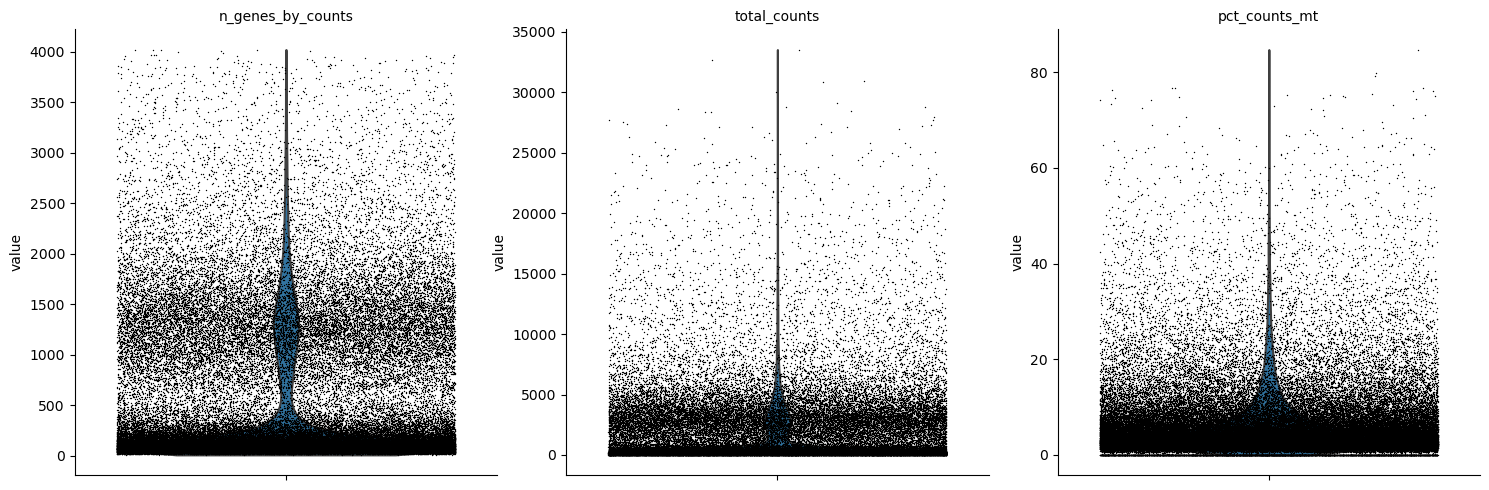

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [10]:
sc.pp.filter_genes(adata, min_cells=3)

/home/amaguza/miniforge3/envs/scanpy_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [11]:
adata.var

,gene_ids,feature_types,seqname,source,feature,start,end,transcript_id,ensembl_trancsript_id_old,ensembl_trancsript_id_cmp_ref,transcript_length,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
gene_name,,,,,,,,,,,,,,,,,,
MAFIP,XLOC_000002,Gene Expression,GL000194.1,ENSEMBL,transcript,53594,115055,TCONS_00000003,ENST00000400754.4,ENST00000400754.4,61462,False,False,14,0.000159,99.984052,14,14
ENSG00000278384,XLOC_000020,Gene Expression,GL000218.1,ENSEMBL,transcript,51867,54893,TCONS_00000027,ENST00000612565.1,ENST00000612565.1,3027,False,False,6,0.000068,99.993165,6,6
ENSG00000273748,XLOC_000021,Gene Expression,GL000219.1,ENSEMBL,transcript,54224,83311,TCONS_00000028,ENST00000612919.1,ENST00000612919.1,29088,False,False,35,0.000399,99.960129,35,35
HSPA1B,XLOC_000083,Gene Expression,GL000250.2,HAVANA,transcript,3160360,3162874,TCONS_00000229,ENST00000450744.1,ENST00000450744.1,2515,False,False,4822,0.084229,94.506972,7394,4822
HSPA1L,XLOC_000161,Gene Expression,GL000250.2,HAVANA,transcript,3142241,3147687,TCONS_00000493,ENST00000426095.2,ENST00000426095.2,5447,False,False,10,0.000114,99.988608,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTY14,XLOC_064961,Gene Expression,chrY,HAVANA,transcript,18772743,19077222,TCONS_00274414,ENST00000651734.1,ENST00000651734.1,304480,False,False,524,0.006425,99.403080,564,524
BCORP1,XLOC_064968,Gene Expression,chrY,HAVANA,transcript,19456394,19567092,TCONS_00274456,ENST00000650676.1,ENST00000650676.1,110699,False,False,64,0.000775,99.927094,68,64
ENSG00000260197,XLOC_064969,Gene Expression,chrY,HAVANA,transcript,19691941,19694606,TCONS_00274460,ENST00000566193.1,ENST00000566193.1,2666,False,False,53,0.000604,99.939625,53,53


In [12]:
adata.write_h5ad('/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Fetal_all_cells/E-MTAB-9536_raw_velocity_anndata_filtered.h5ad')